In [1]:
from scipy.optimize import curve_fit
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.style.use('fivethirtyeight')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Define which Curve You want to Study
File_name = 'HS01DataDCA.csv'
Variable = 'Gas Volume'
Forcasting_Time = 4500 # Dependes on the size of the data

# Arps's Decline Curves

In [3]:
Well = pd.read_csv(File_name)

T = Well['Time (Days)'].T
Q = Well[Variable].T

Well.head()

,Time (Days),Gas Volume,Oil Volume,Water Volume
0,1,4.45783,0.0,332.0
1,2,10.23198,0.0,482.0
2,3,11.90695,0.0,541.0
3,4,11.73224,0.0,556.0
4,5,10.88005,0.0,538.0


In [4]:
# Theory into Code

## We define Type Arps's Curves and modified hyperbolic
def decline_curve(curve_type, q_i):
    if curve_type == "exponential":
        def exponential_decline(T, a_i):
            return q_i*np.exp(-a_i*T)
        return exponential_decline
    
    elif curve_type == "hyperbolic":
        def hyperbolic_decline(T, a_i, b):
            return q_i/((1+b*a_i*T)**(1./b))
        return hyperbolic_decline
    
    elif curve_type == "harmonic":
        def harmonic_decline(T, a_i):
            return q_i/(1+a_i*T)
        return harmonic_decline
    
    else:
        raise "This Decline curve is not defined"


## We Extract the Highest Rate in the first Month = 30 days
def GetMaxInitialProd(DataFrame, Number_of_Time_frame, VariableName, DateColumn):
    
    """
    This function allows you to look at the first X Time-frames of production, and selects 
    the highest production day as max initial production 
    """
    
    #First, sort the data frame from earliest to most recent prod date
    DataFrame=DataFrame.sort_values(by=DateColumn)
    
    #Pull out the first x months of production, where Number_of_Time_frame is x
    DF_Begining_Production = DataFrame.head(Number_of_Time_frame)
    
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return DF_Begining_Production[VariableName].max()


## We define our curves with initial rate which we will chose as the highest rate in the 30 first days
Qi = GetMaxInitialProd(Well, 30, Variable, "Time (Days)")



exp_decline = decline_curve("exponential", Qi)
hyp_decline = decline_curve("hyperbolic", Qi)
har_decline = decline_curve("harmonic", Qi)

popt_exp, pcov_exp = curve_fit(exp_decline, T, Q, method="trf") # Trust Region Reflective
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T, Q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T, Q, method="trf")

## We use our Mean squared error regression loss in order to check the fitness of our model


print("Mean squared error regression loss of Exponential Decline: ", mean_squared_error(exp_decline(T, popt_exp[0]), Q))
print("Mean squared error regression loss of hyperbolic decline: ", mean_squared_error(hyp_decline(T, popt_hyp[0], popt_hyp[1]), Q))
print("Mean squared error regression loss of harmonic  decline: ", mean_squared_error(har_decline(T, popt_har[0]), Q))

print("Le taux de Déclin D exponentiel:", popt_exp[0])
print("Le taux de Déclin D hyperbolic et le coeffecient b sont:", popt_hyp[0], popt_hyp[1])
print("Le taux de Déclin D harmonic:", popt_har[0])

Mean squared error regression loss of Exponential Decline:  0.3477944549370204
Mean squared error regression loss of hyperbolic decline:  0.06087650131659367
Mean squared error regression loss of harmonic  decline:  0.07299722461723099
Le taux de Déclin D exponentiel: 0.013282635447468136
Le taux de Déclin D hyperbolic et le coeffecient b sont: 0.03825676585707216 1.2272880284077978
Le taux de Déclin D harmonic: 0.02883529211518589


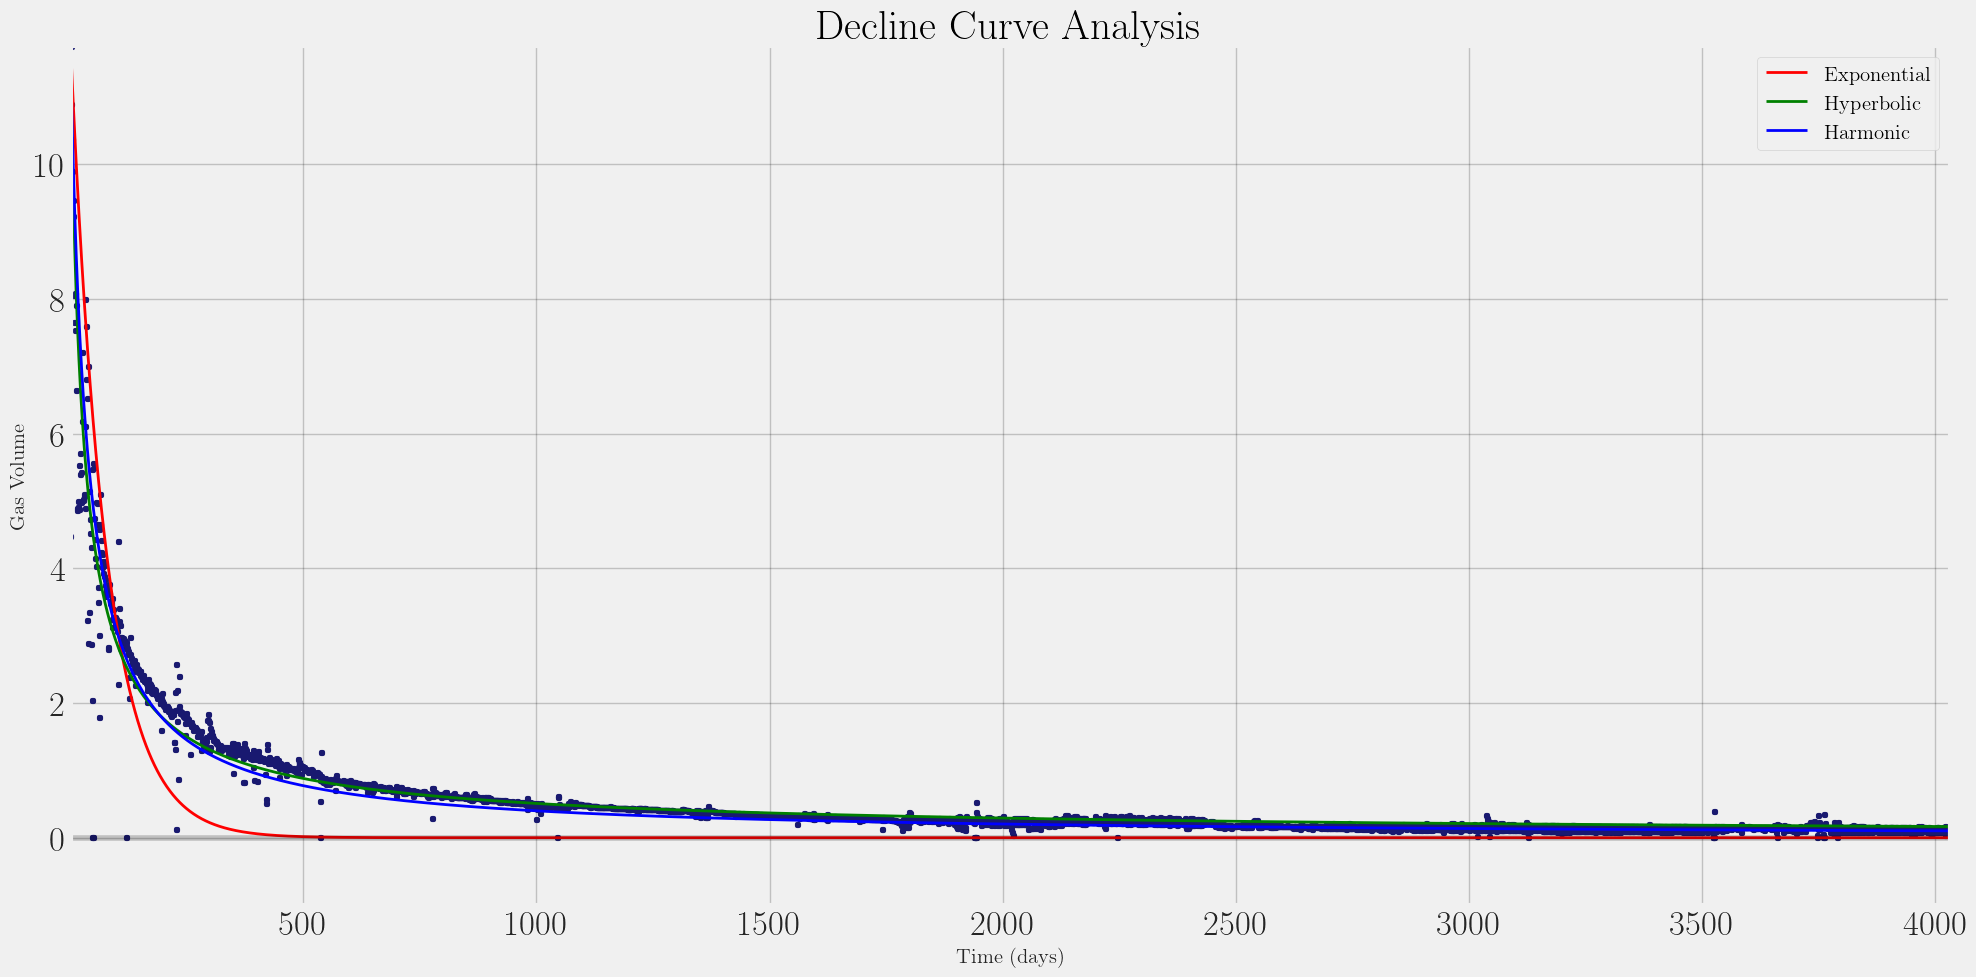

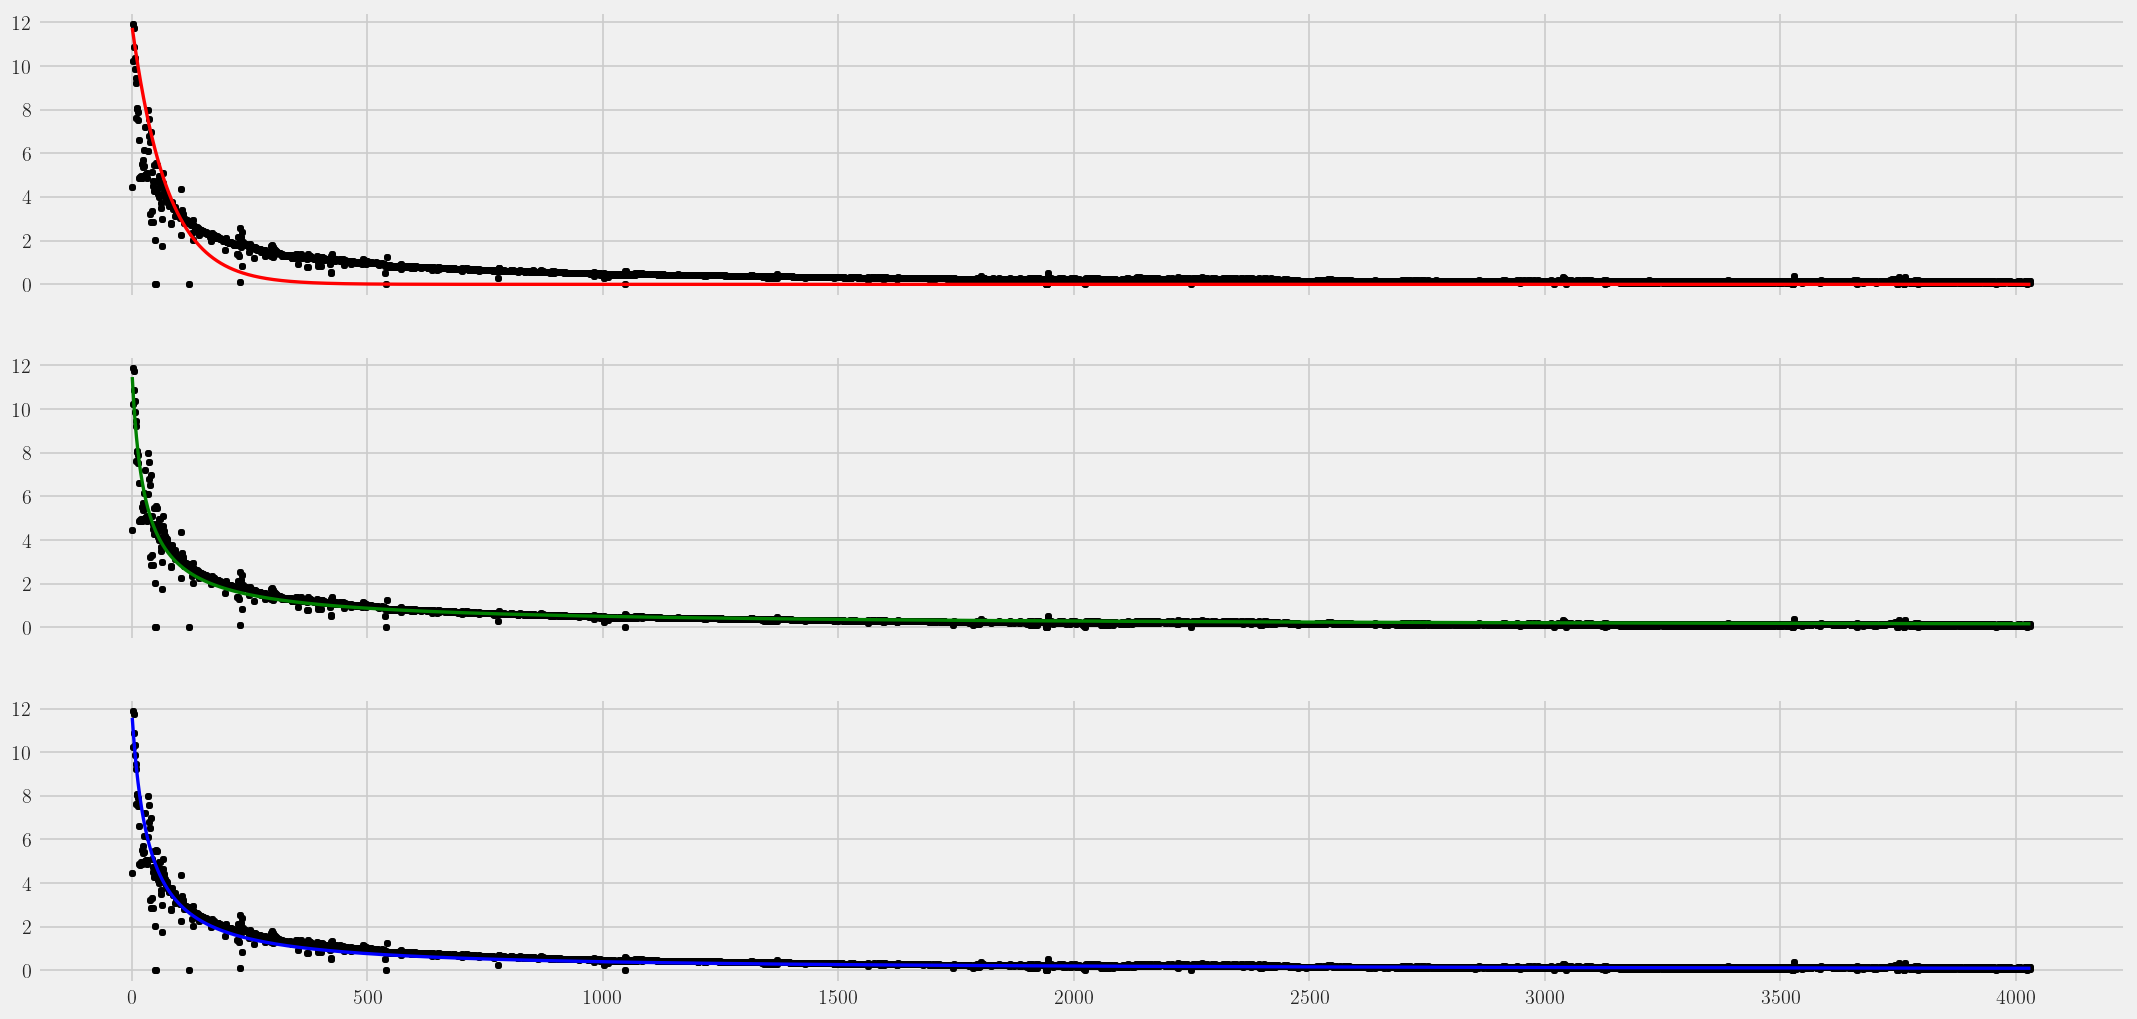

In [5]:
## Doing some ploting to check

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.set_title("Decline Curve Analysis", fontsize=30)

label_size = 25
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="midnightblue", marker=",", s=1, linewidth=3)
ax.set_xlabel("Time (days)", fontsize=15)
ax.set_ylabel(Variable , fontsize=15)

pred_exp = exp_decline(T, popt_exp[0])
pred_hyp = hyp_decline(T, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T, popt_har[0])


min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

#Same Plot
ax.plot(T, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
ax.plot(T, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
ax.plot(T, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig('ArpsDeclineCurvesBeforeProssessingHS01.png')


# Different Plots
fig, axes = plt.subplots(3,1, figsize=(20, 10), sharex=True, dpi=120)
axes[0].plot(T, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
axes[0].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
axes[1].plot(T, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
axes[1].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
axes[2].plot(T, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
axes[2].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)

fig.savefig('ArpsDeclineCurvesBeforeProssessingIndiviudalHS01.png')

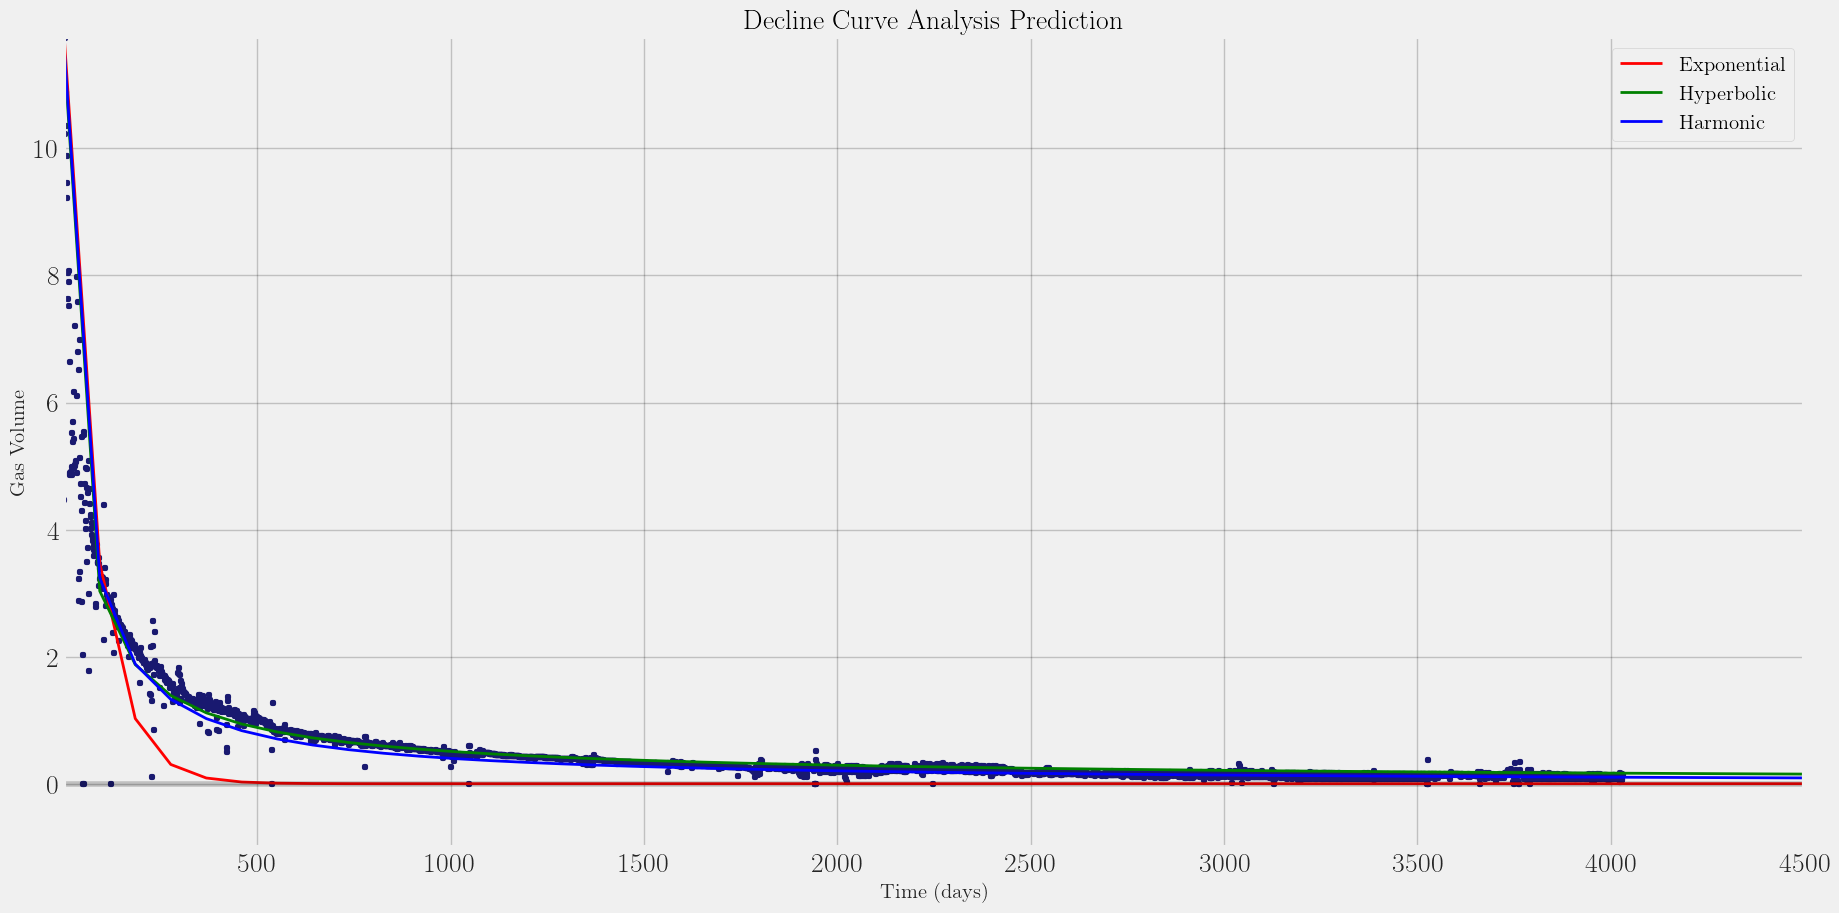

In [6]:
# Let us predict the next 10 years

fig, ax = plt.subplots(1, figsize=(20, 10))

T_max = Forcasting_Time
T_pred = np.linspace(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction", fontsize=20)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="midnightblue", marker=",", s=1, linewidth=3)
ax.set_xlabel("Time (days)", fontsize=15)
ax.set_ylabel(Variable , fontsize=15)

pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])



min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
ax.plot(T_pred, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
ax.plot(T_pred, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)

fig.savefig('ArpsDeclineCurvesBeforeProssessingForecastingHS01.png')

# Logistic Growth Model

The Carrying Capacity K equals: 390864.8844056303
The hyperbolic exponent n equals: 0.8101097811776631
The constant a equals: 161.6785577339692
Mean squared error regression loss of LGM:  0.060338597543788536


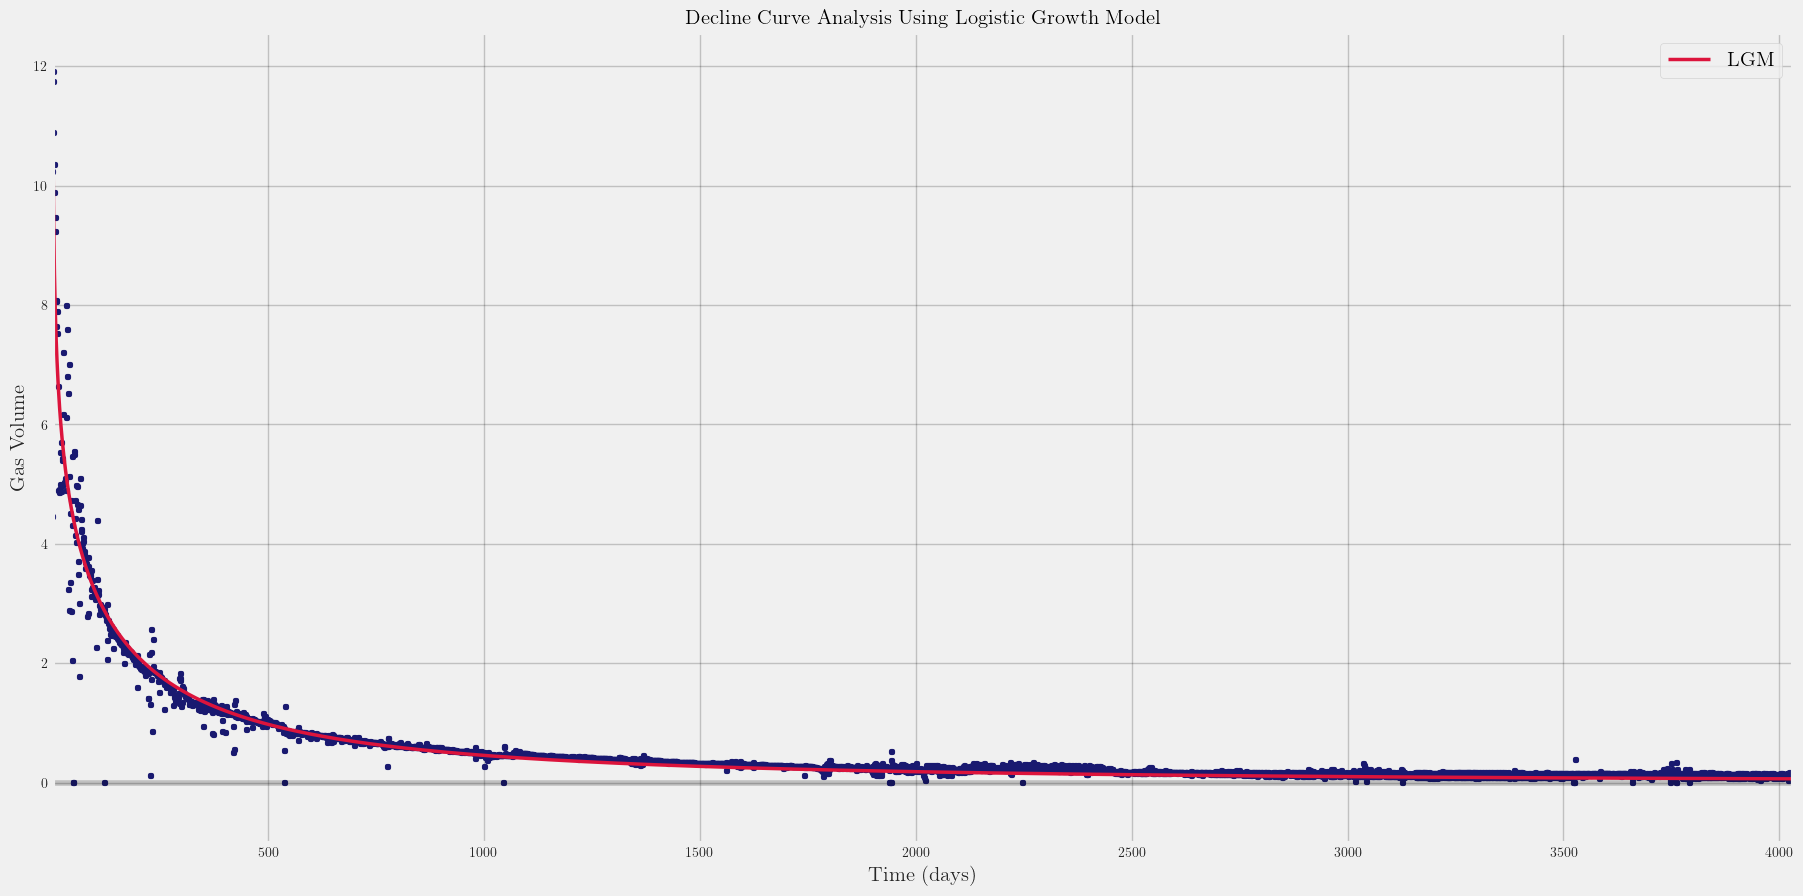

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Estimate Paramaters

## The carrying capacity is the total amount of oil or gas recoverable from primary 
# depletion in the well
K_estim = 150

## The n serves to control the decline behavior of the model, 
#and it allows it to be more flexible to better fit the production data
n_estim = 1.1

## The third parameter, a, is the time to the power n at which half of the carrying capacity 
# has been produced.
a_estim = 3



# Model Definntion
def LGM(T,  K, n, a):
    return (K*n*T**(n-1))/((T**n + a)**2)

# Fitting
popt_LGM, pcov_LGM = curve_fit(LGM, T, Q, p0=(K_estim, n_estim, a_estim), maxfev=10000)
K = popt_LGM[0]
n = popt_LGM[1]
a = popt_LGM[2]

print("The Carrying Capacity K equals:", K)
print("The hyperbolic exponent n equals:", n)
print("The constant a equals:", a)


# Predection
pred_LGM = LGM(T, K, n, a)

## We use our L^2 norm in order to check the fitness of our model



print("Mean squared error regression loss of LGM: ", mean_squared_error(pred_LGM, Q))
# Plotting
fig, ax = plt.subplots(1, figsize=(20, 10))

ax.set_title("Decline Curve Analysis Using Logistic Growth Model", fontsize=15)

label_size = 10
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="midnightblue", marker=",", s=1, linewidth=3)
ax.set_xlabel("Time (days)", fontsize=15)
ax.set_ylabel(Variable , fontsize=15)

pred_LGM = LGM(T, K, n, a)


ax.plot(T, pred_LGM, color="crimson", linewidth=2.5, alpha=1, label="LGM")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)

fig.savefig('LGMBeforeProssessingHS01.png')


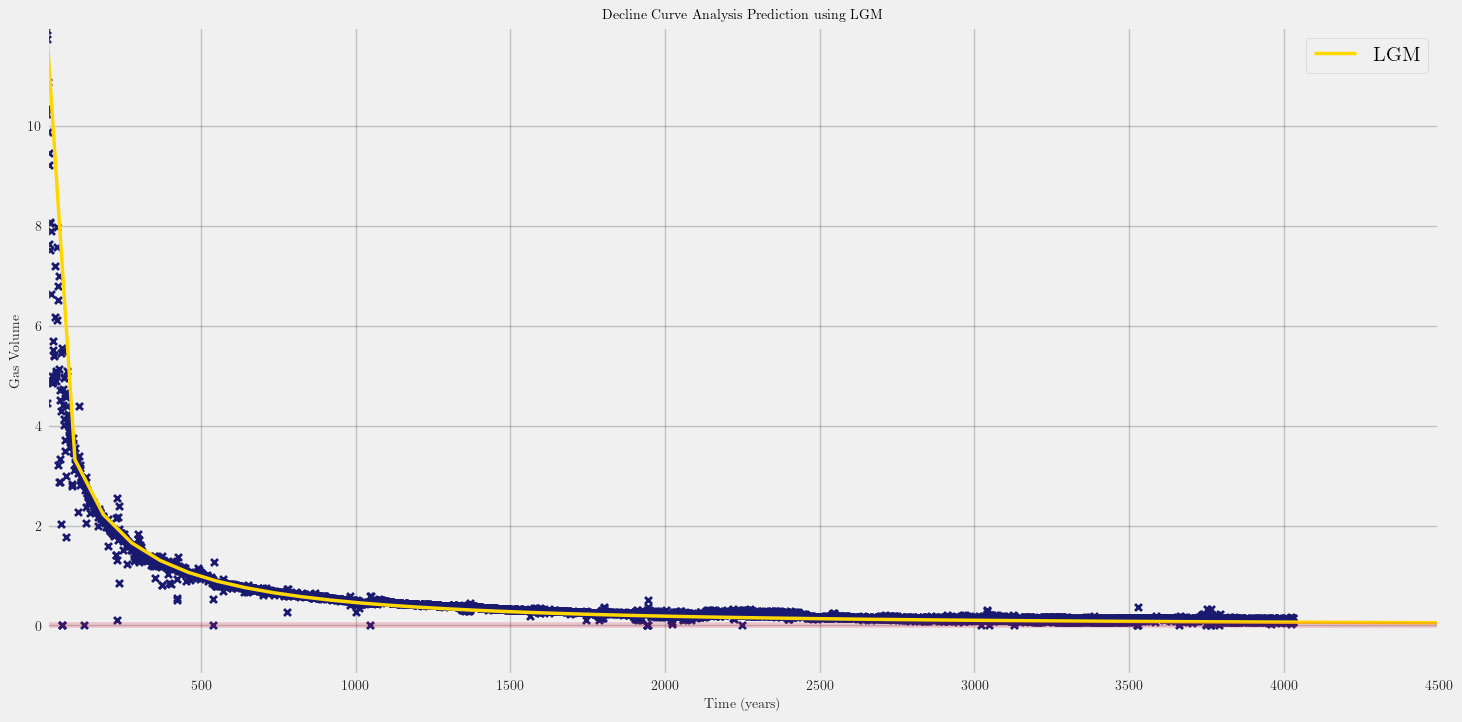

In [8]:
# Forecasting next 10 years

fig, ax = plt.subplots(1, figsize=(16, 8))

T_max = Forcasting_Time
T_pred = np.linspace(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction using LGM", fontsize=10)

label_size = 10
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="midnightblue", marker="x", s=25, linewidth=2)
ax.set_xlabel("Time (years)", fontsize=10)
ax.set_ylabel(Variable , fontsize=10)

pred_LGM = LGM(T_pred, K, n, a)


min_val = min([min(curve) for curve in [pred_LGM]])
max_val = max([max(curve) for curve in [pred_LGM]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_LGM, color="gold", linewidth=2.5, alpha=1, label="LGM")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='crimson', alpha=0.2)
ax.legend(fontsize=15)

fig.savefig('LGMBeforeProssessingForecastingHS01.png')

# Some Data Processing

In [9]:
# Import
df_orig = pd.read_csv(File_name)
# 1. Moving Average To smothen the curve
df_ma_3 = df_orig[Variable].rolling(3, center=True, closed='both').mean() # 3 Days mean
df_ma_5 = df_orig[Variable].rolling(5, center=True, closed='both').mean() # 5 Days mean
df_ma_30 = df_orig[Variable].rolling(30, center=True, closed='both').mean() # 30 Days mean

<AxesSubplot: title={'center': 'Moving Average (30)'}>

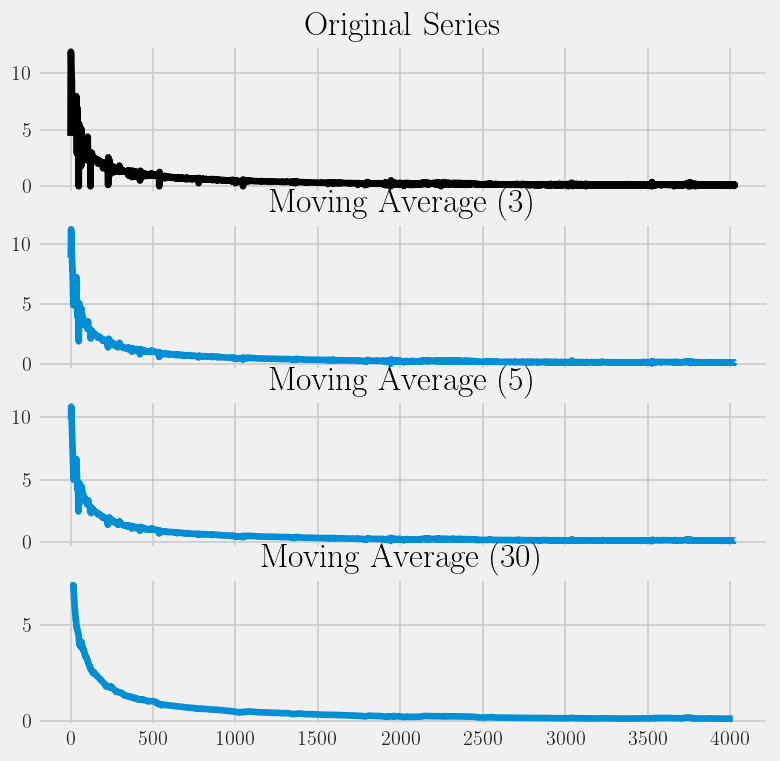

In [10]:
# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df_orig[Variable].plot(ax=axes[0], color='k', title='Original Series')
df_ma_3.plot(ax=axes[1], title='Moving Average (3)')
df_ma_5.plot(ax=axes[2], title='Moving Average (5)')
df_ma_30.plot(ax=axes[3], title='Moving Average (30)')

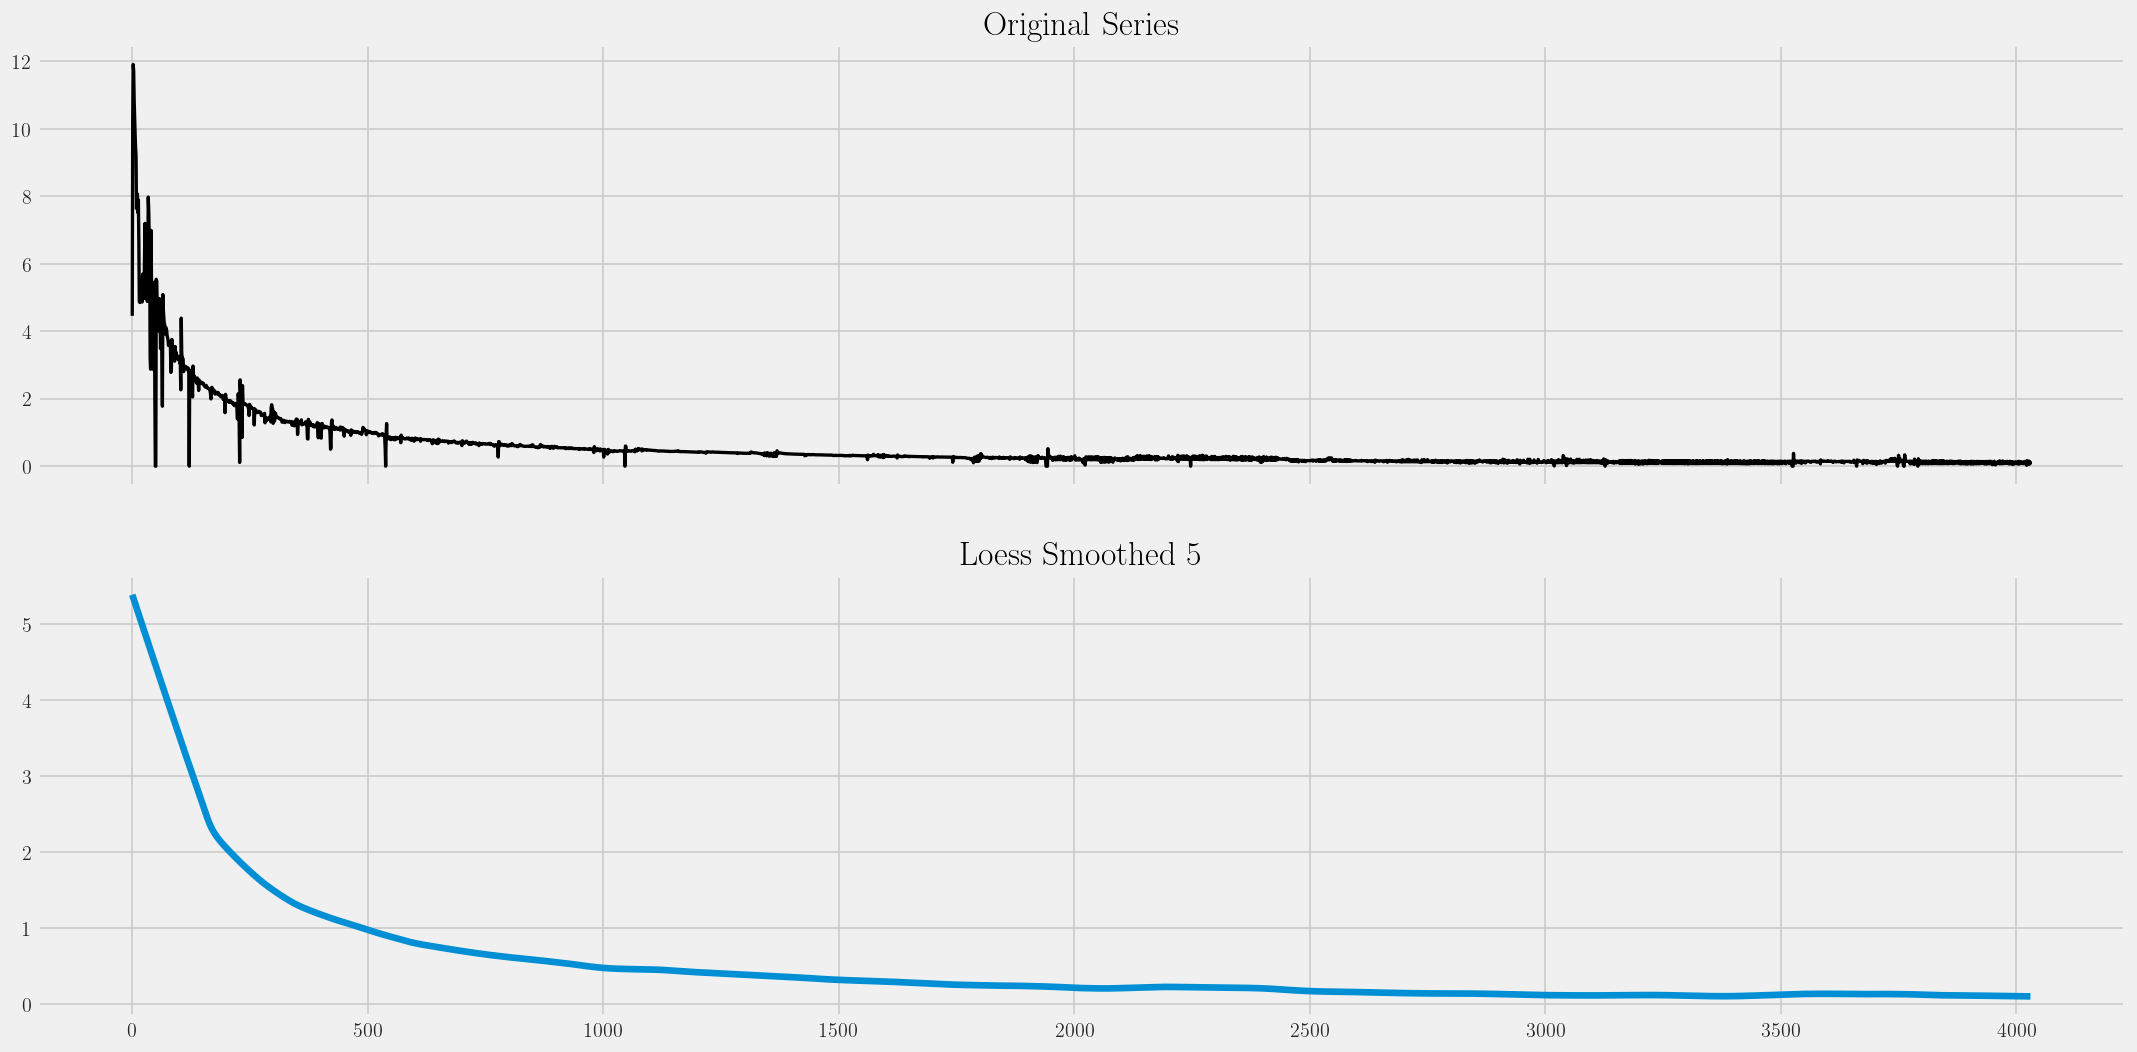

In [11]:
# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df_orig[Variable], np.arange(len(df_orig[Variable])), frac=0.05)[:, 1], index=df_orig.index, columns=[Variable])
df_loess_15 = pd.DataFrame(lowess(df_orig[Variable], np.arange(len(df_orig[Variable])), frac=0.15)[:, 1], index=df_orig.index, columns=[Variable])

# Plot
fig, axes = plt.subplots(2,1, figsize=(20, 10), sharex=True, dpi=120)
df_orig[Variable].plot(ax=axes[0], color='k', linewidth=2, title='Original Series')
df_loess_5[Variable].plot(ax=axes[1], title='Loess Smoothed 5%')
#df_loess_15[Variable].plot(ax=axes[2], title='Loess Smoothed 15%')

fig.savefig('LoessSmootheningHS01.png')

In [12]:
Well[Variable + 'SLoess'] =  df_loess_5[Variable]
Well[Variable + 'SMA'] = df_orig[Variable].rolling(30, center=True, closed='both').mean()

In [13]:
Well

,Time (Days),Gas Volume,Oil Volume,Water Volume,Gas VolumeSLoess,Gas VolumeSMA
0,1,4.45783,0.0,332.00,5.382578,NaN
1,2,10.23198,0.0,482.00,5.363678,NaN
2,3,11.90695,0.0,541.00,5.344783,NaN
3,4,11.73224,0.0,556.00,5.325894,NaN
4,5,10.88005,0.0,538.00,5.307011,NaN
...,...,...,...,...,...,...
4026,4027,0.14167,NaN,0.00,0.105914,NaN
4027,4028,0.06459,NaN,0.14,0.105833,NaN
4028,4029,0.14653,NaN,1.01,0.105752,NaN
4029,4030,0.06990,NaN,0.00,0.105672,NaN


# Using Our smoothend Data LOESS to Do the Analysis with Arps Curves

In [14]:
exp_decline = decline_curve("exponential", Qi)
hyp_decline = decline_curve("hyperbolic", Qi)
har_decline = decline_curve("harmonic", Qi)

Qs = Well[Variable + 'SLoess'].T

popt_exp, pcov_exp = curve_fit(exp_decline, T, Qs, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T, Qs, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T, Qs, method="trf")

## We use our L^2 norm in order to check the fitness of our model

print("Mean squared error regression loss of Exponential Decline: ", mean_squared_error(exp_decline(T, popt_exp[0]), Qs))
print("Mean squared error regression loss of hyperbolic decline: ", mean_squared_error(hyp_decline(T, popt_hyp[0], popt_hyp[1]), Qs))
print("Mean squared error regression loss of harmonic  decline: ", mean_squared_error(har_decline(T, popt_har[0]), Qs))


print("Le taux de Déclin D exponentiel:", popt_exp[0])
print("Le taux de Déclin D hyperbolic et le coeffecient b sont:", popt_hyp[0], popt_hyp[1])
print("Le taux de Déclin D harmonic:", popt_har[0])

Mean squared error regression loss of Exponential Decline:  0.43054380791676033
Mean squared error regression loss of hyperbolic decline:  0.08732125373496391
Mean squared error regression loss of harmonic  decline:  0.11674874236984824
Le taux de Déclin D exponentiel: 0.012587927097057961
Le taux de Déclin D hyperbolic et le coeffecient b sont: 0.050659728512804265 1.394883308050085
Le taux de Déclin D harmonic: 0.029224590048363027


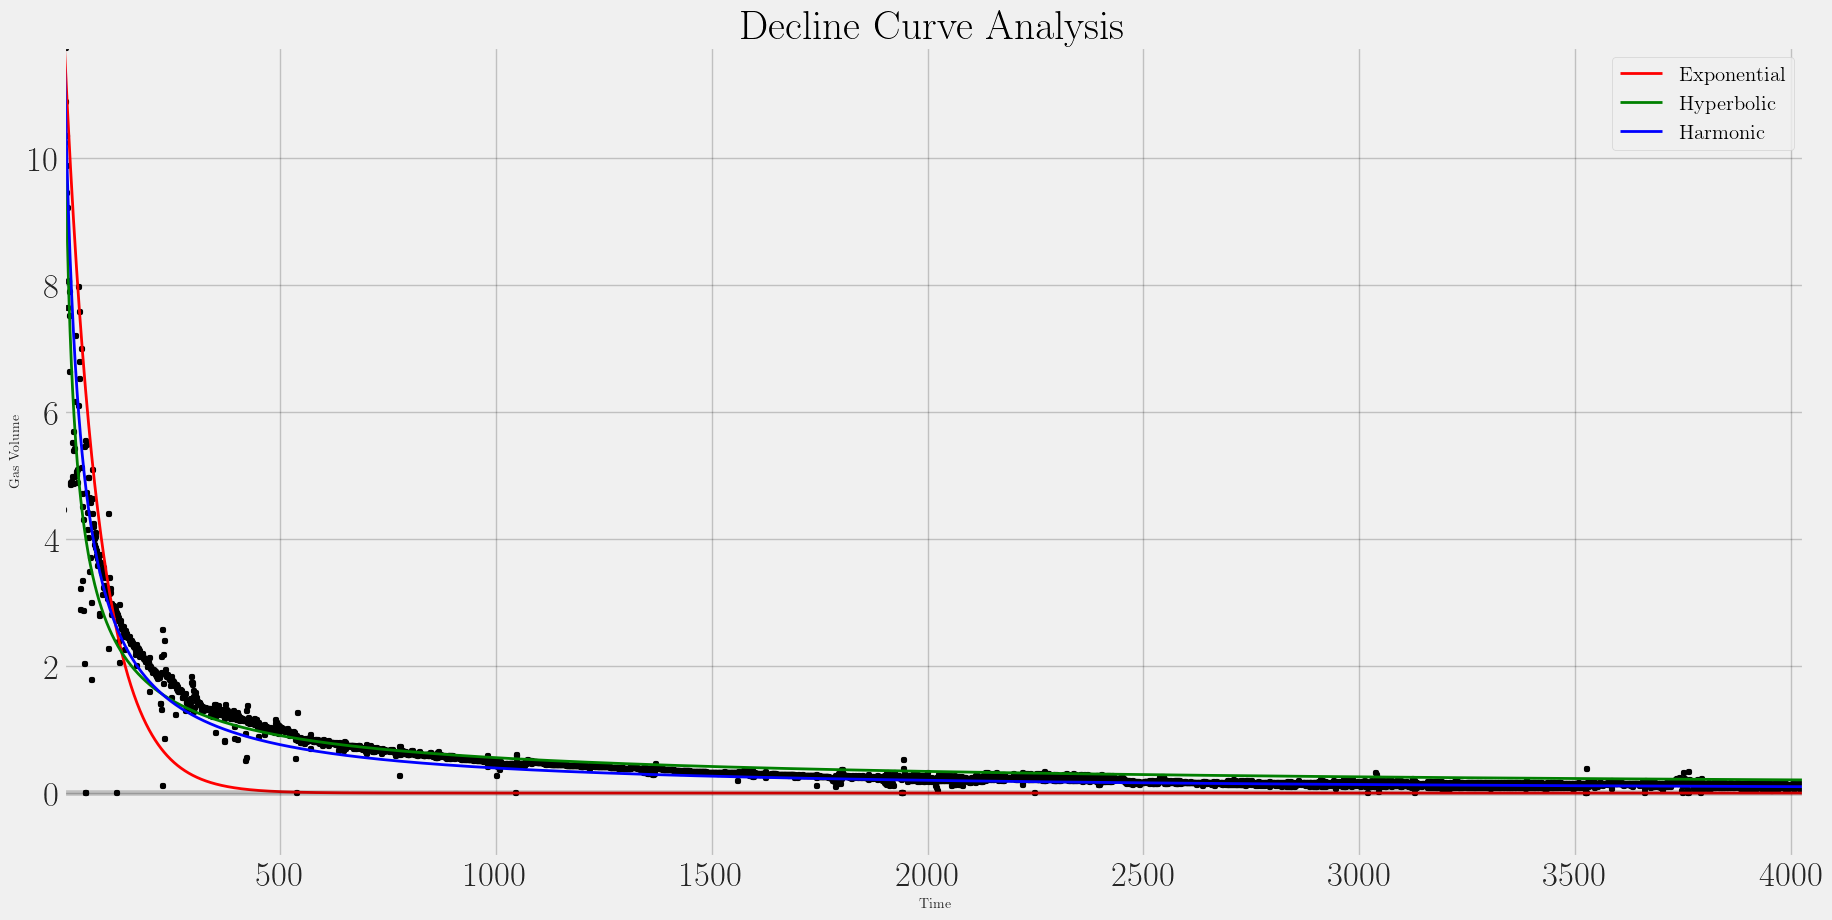

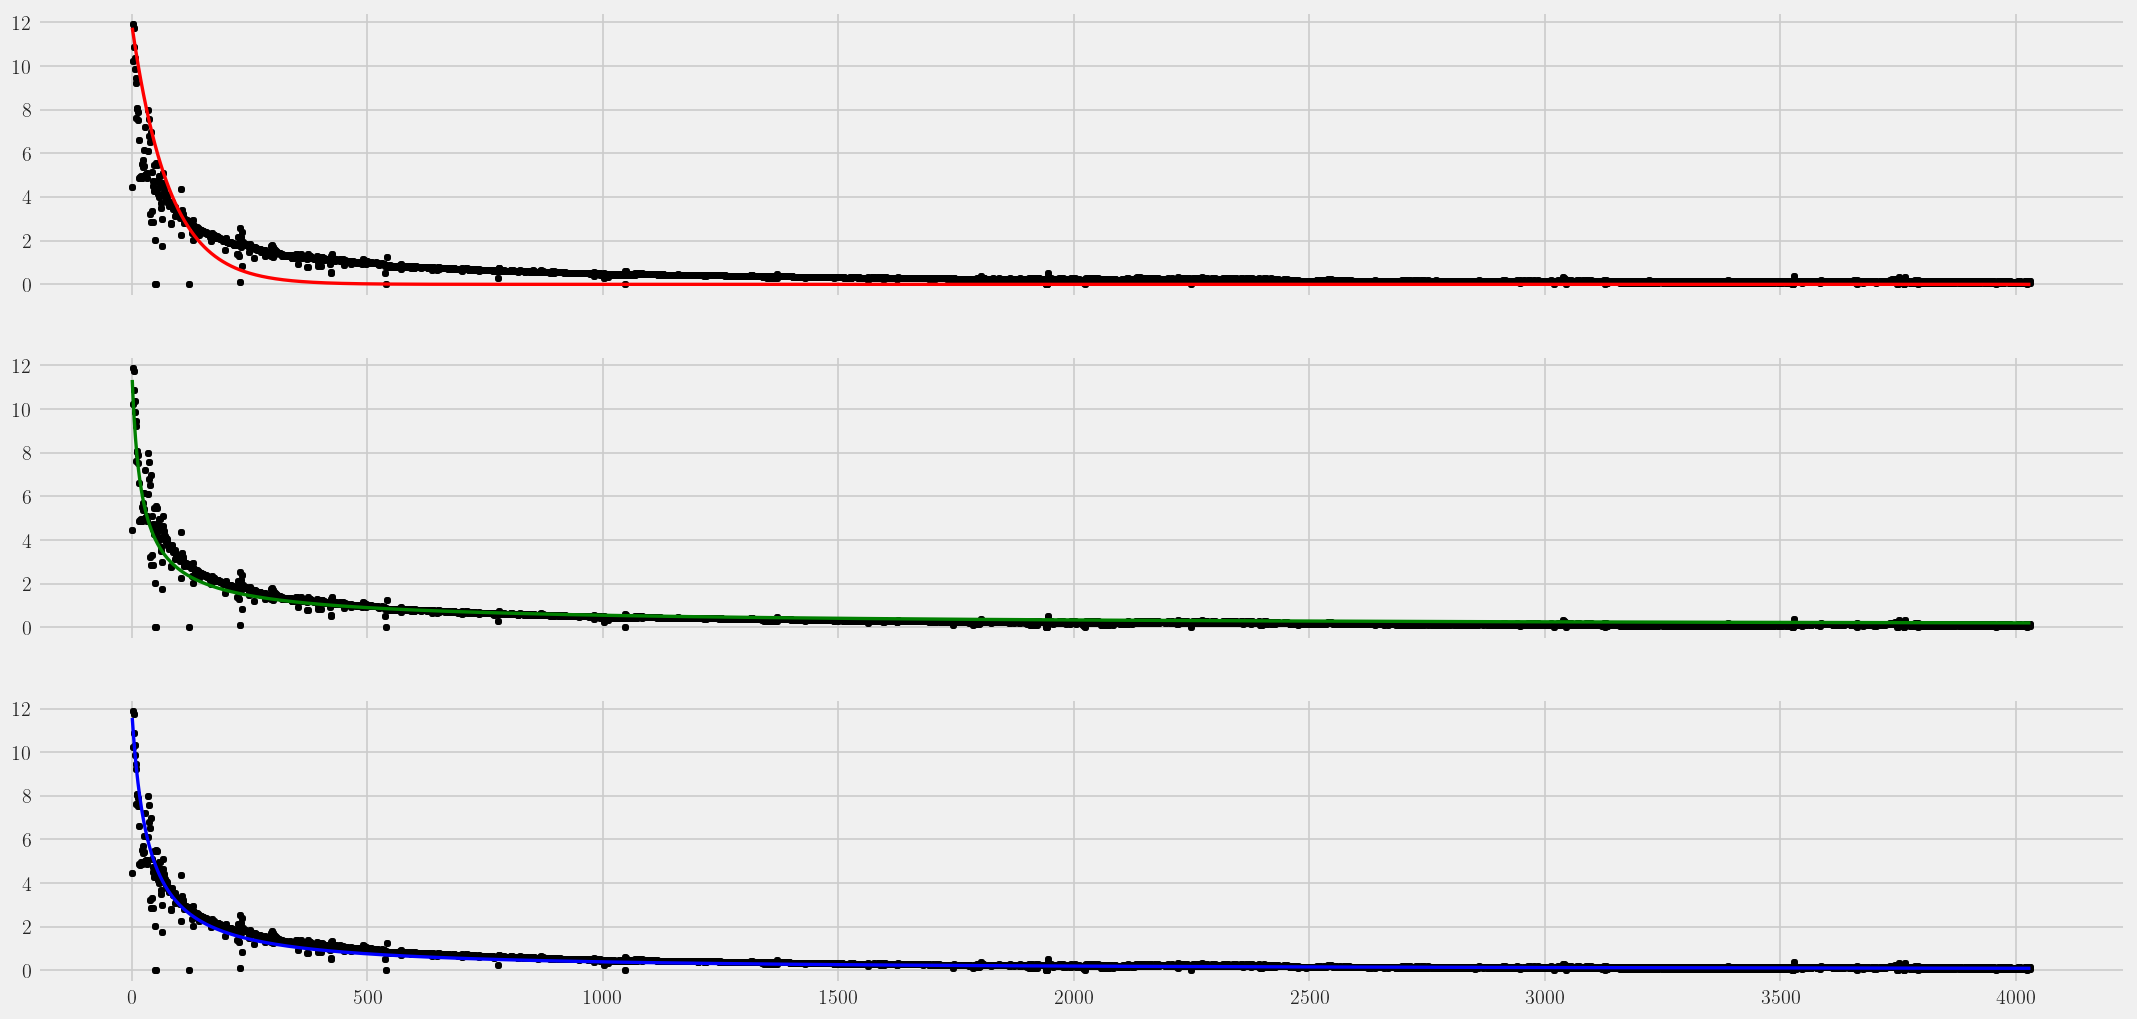

In [15]:
## Doing some ploting to check

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.set_title("Decline Curve Analysis", fontsize=30)

label_size = 25
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel(Variable, fontsize=10)

pred_exp = exp_decline(T, popt_exp[0])
pred_hyp = hyp_decline(T, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T, popt_har[0])


min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
ax.plot(T, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
ax.plot(T, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)
fig.savefig('ArpsDeclineCurvesAfterProssessingHS01.png')



fig, axes = plt.subplots(3,1, figsize=(20, 10), sharex=True, dpi=120)
axes[0].plot(T, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
axes[0].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
axes[1].plot(T, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
axes[1].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
axes[2].plot(T, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
axes[2].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)

fig.savefig('ArpsDeclineCurvesAfterProssessingIndividualHS01.png')


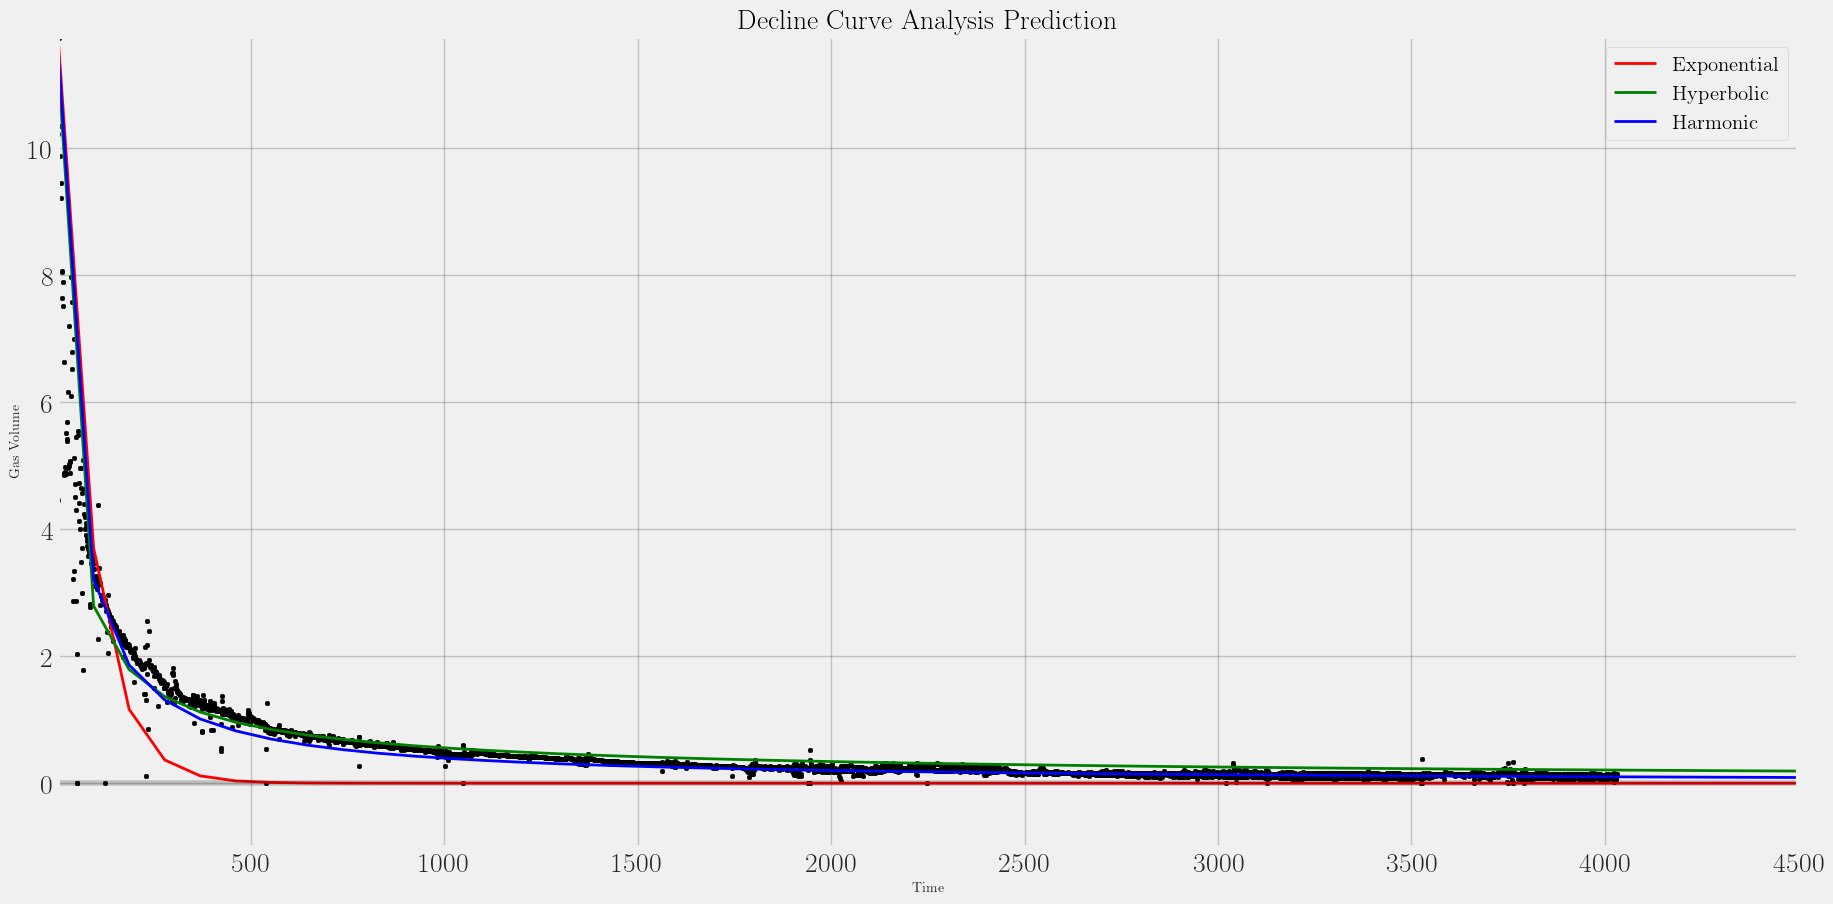

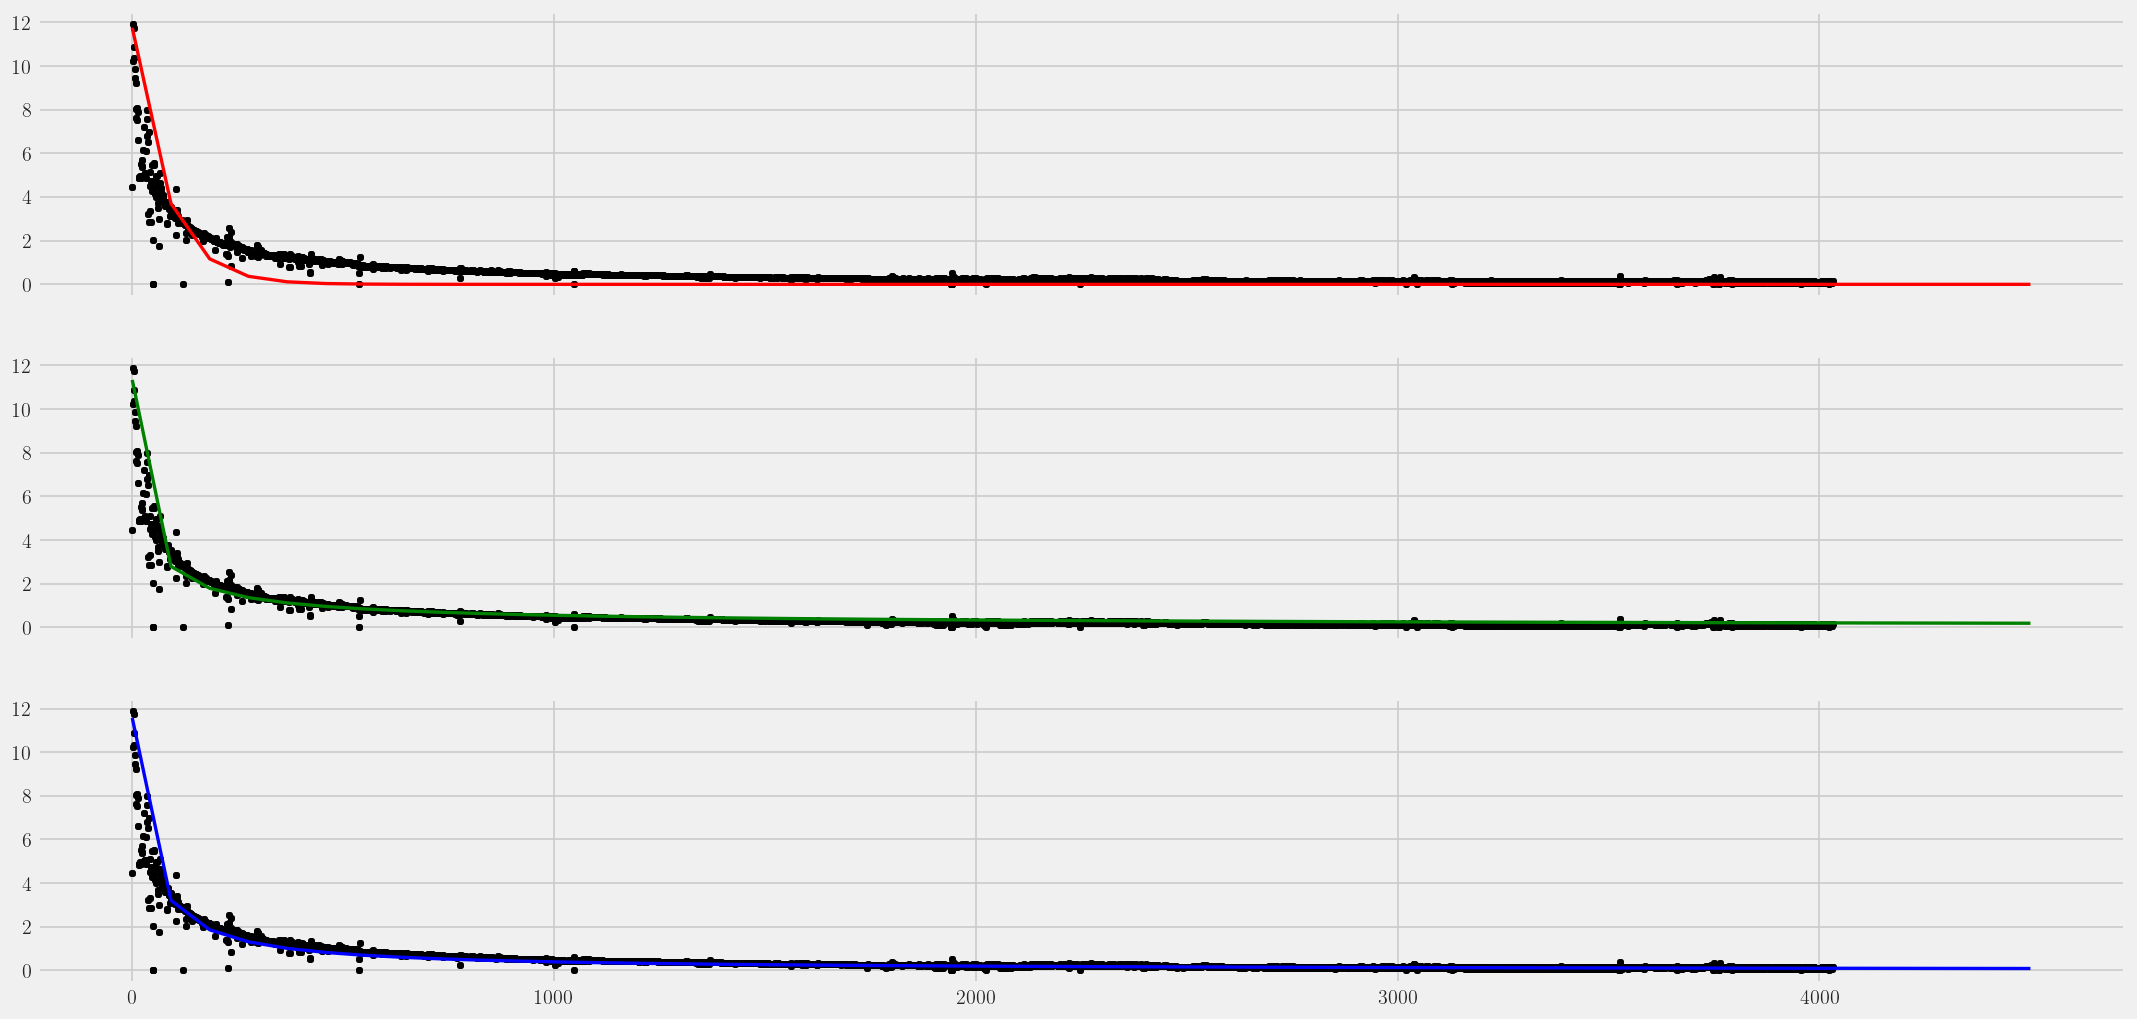

In [16]:
# Let us predict the next 10 years

fig, ax = plt.subplots(1, figsize=(20, 10))

T_max = Forcasting_Time
T_pred = np.linspace(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction", fontsize=20)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="black", marker=",", s=1, linewidth=2)
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel(Variable, fontsize=10)

pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])



min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
ax.plot(T_pred, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
ax.plot(T_pred, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)
fig.savefig('ArpsDeclineCurvesAfterProssessingForecastingHS01.png')

#Diffrent Plots
fig, axes = plt.subplots(3,1, figsize=(20, 10), sharex=True, dpi=120)
axes[0].plot(T_pred, pred_exp, color="red", linewidth=2, alpha=1, label="Exponential")
axes[0].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
axes[1].plot(T_pred, pred_hyp, color="green", linewidth=2, alpha=1, label="Hyperbolic")
axes[1].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
axes[2].plot(T_pred, pred_har, color="blue", linewidth=2, alpha=1, label="Harmonic")
axes[2].scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
fig.savefig('ArpsDeclineCurvesAfterProssessingForecastingIndividualHS01.png')

# Using Our smoothend Data to Do the Analysis with LGM

In [17]:
## The carrying capacity is the total amount of oil or gas recoverable from primary 
# depletion in the well
K_estim = 150

## The n serves to control the decline behavior of the model, 
#and it allows it to be more flexible to better fit the production data
n_estim = 1.1

## The third parameter, a, is the time to the power n at which half of the carrying capacity 
# has been produced.
a_estim = 3



# Model Definntion
def LGM(T,  K, n, a):
    return (K*n*T**(n-1))/((T**n + a)**2)

# Fitting
popt_LGM, pcov_LGM = curve_fit(LGM, T,  Well[Variable + 'SLoess'], p0=(K_estim, n_estim, a_estim), maxfev=10000)
K = popt_LGM[0]
n = popt_LGM[1]
a = popt_LGM[2]

print("The Carrying Capacity K equals:", K)
print("The hyperbolic exponent n equals:", n)
print("The constant a equals:", a)

## We define the L^2 norm which a way of telling which model is doing best 
def L2_norm(Q, Q_obs):
    return np.sum(np.power(np.subtract(Q, Q_obs), 2))


# Predection
pred_LGM = LGM(T, K, n, a)

## We use our L^2 norm in order to check the fitness of our model

print("Mean squared error regression loss of LGM: ", mean_squared_error(pred_LGM, Qs))

The Carrying Capacity K equals: 714143.3613195344
The hyperbolic exponent n equals: 0.9503623356172034
The constant a equals: 325.2264623213262
Mean squared error regression loss of LGM:  0.008004320296503794


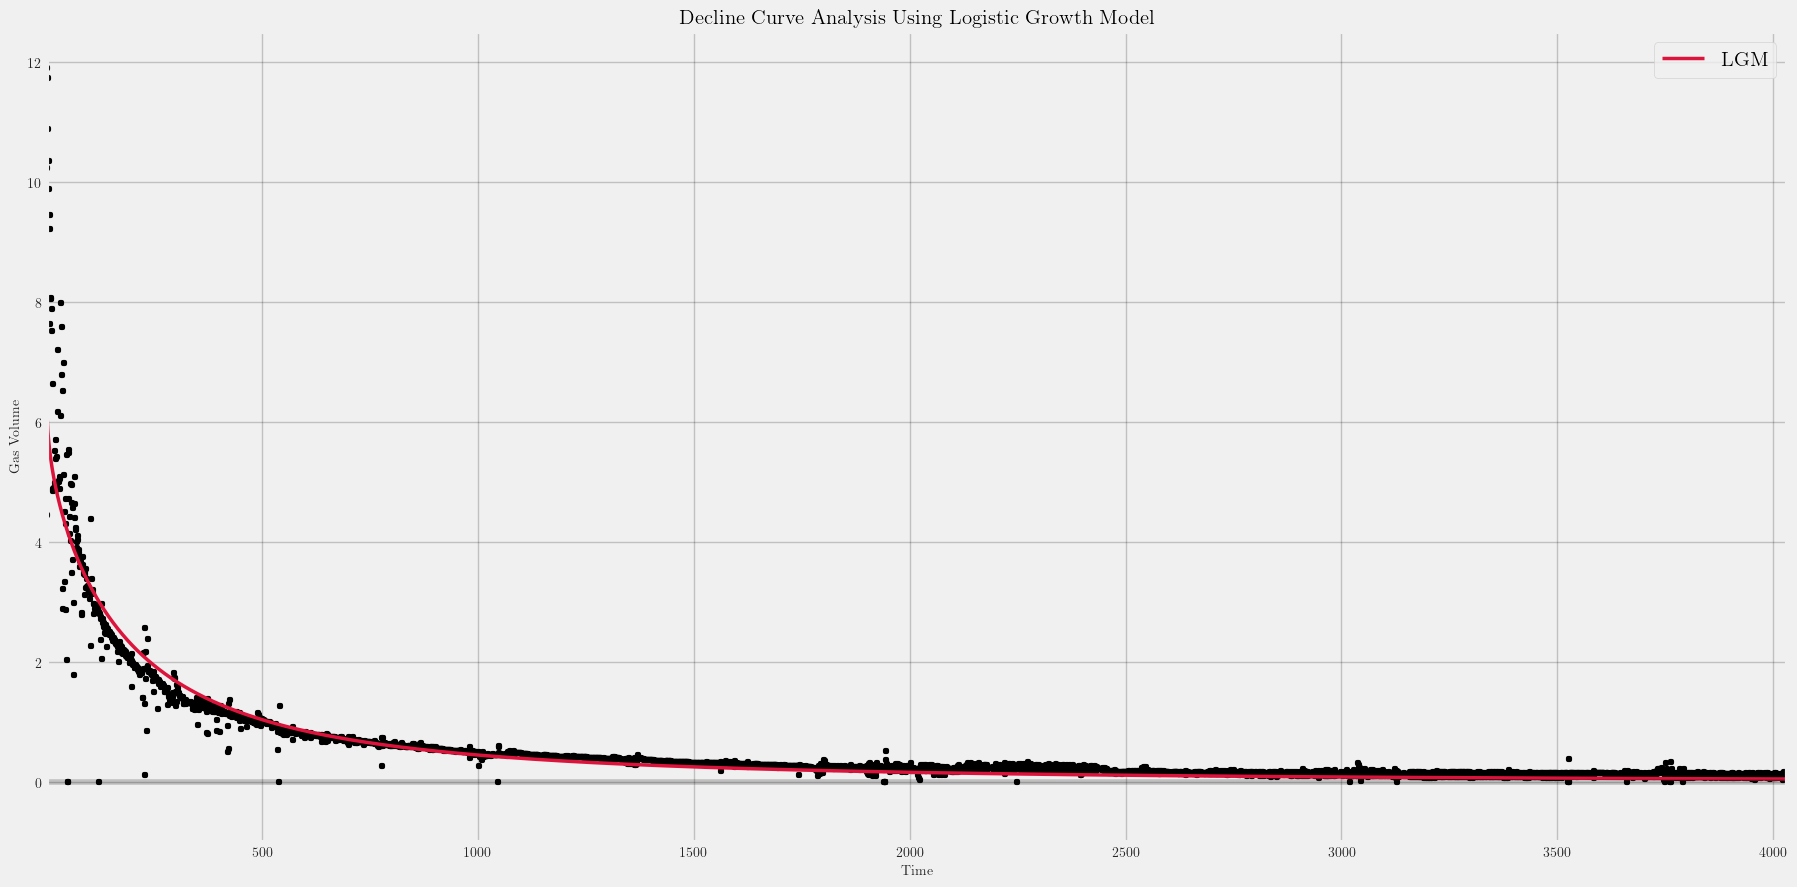

In [18]:
# Plotting
fig, ax = plt.subplots(1, figsize=(20, 10))

ax.set_title("Decline Curve Analysis Using Logistic Growth Model", fontsize=15)

label_size = 10
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="black", marker=",", s=1, linewidth=3)
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel(Variable, fontsize=10)

pred_LGM = LGM(T, K, n, a)


ax.plot(T, pred_LGM, color="crimson", linewidth=2.5, alpha=1, label="LGM")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)

fig.savefig('LGMAfterProssessingHS01.png')


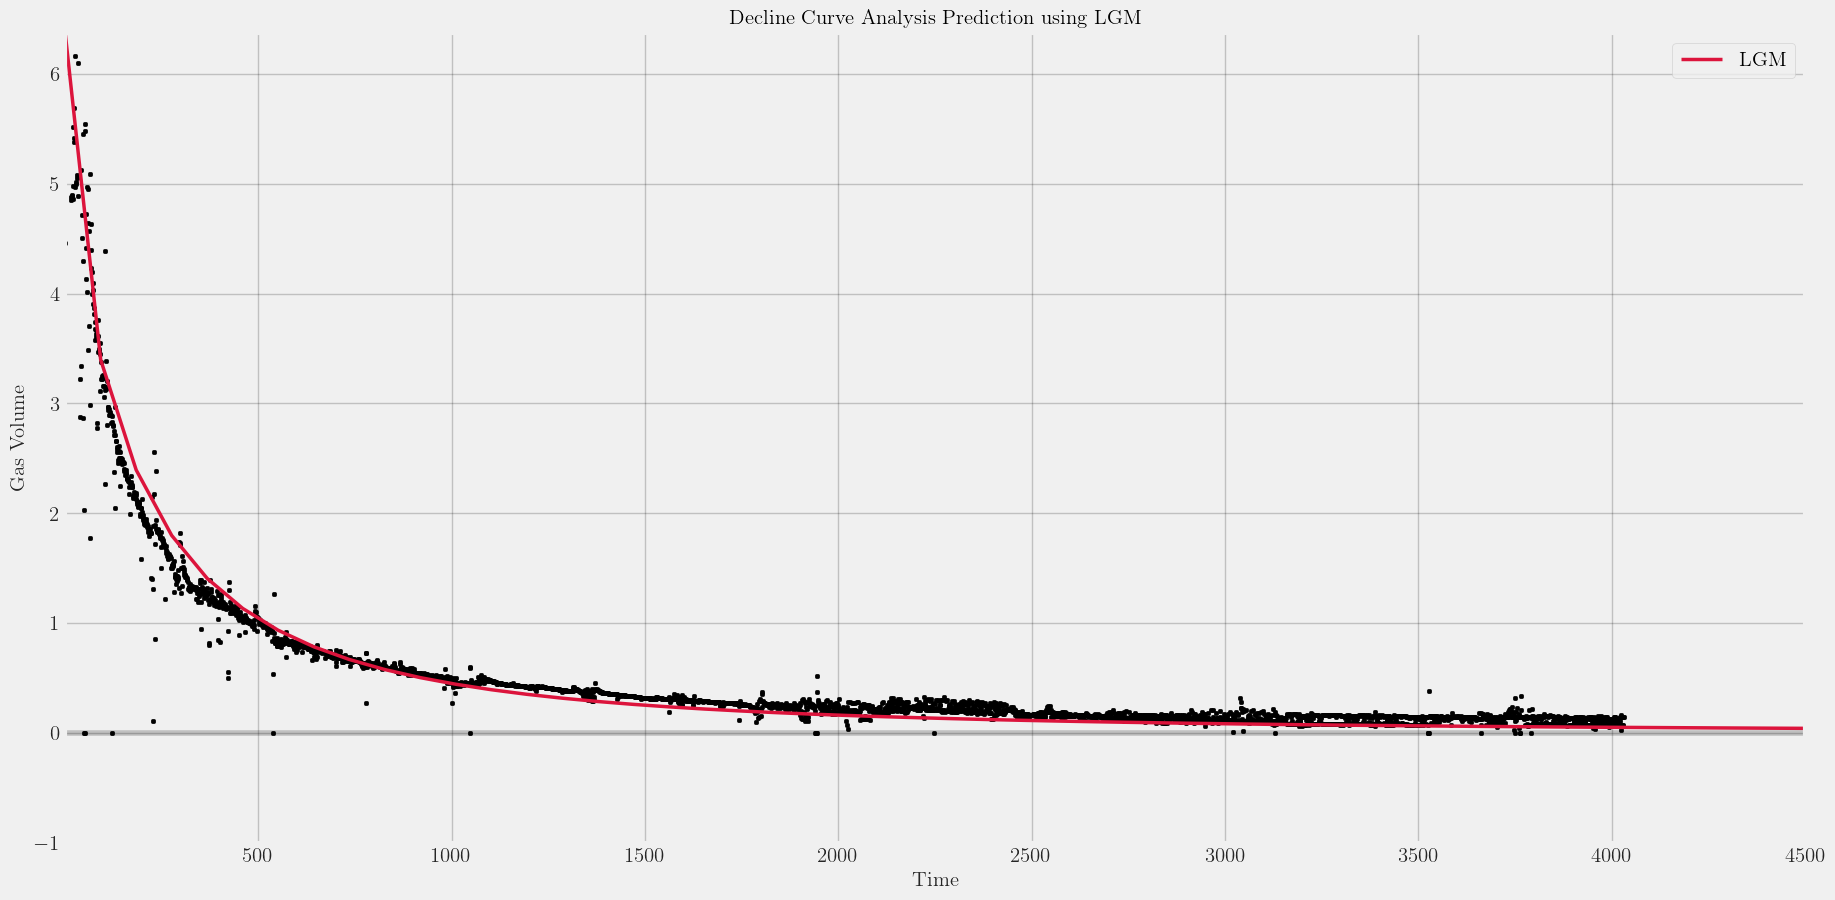

In [19]:
# Forecasting next 10 years

fig, ax = plt.subplots(1, figsize=(20, 10))

T_max = Forcasting_Time
T_pred = np.linspace(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction using LGM", fontsize=15)

label_size = 15
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="black", marker=",", s=1, linewidth=2)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel(Variable, fontsize=15)

pred_LGM = LGM(T_pred, K, n, a)


min_val = min([min(curve) for curve in [pred_LGM]])
max_val = max([max(curve) for curve in [pred_LGM]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_LGM, color="crimson", linewidth=2.5, alpha=1, label="LGM")
ax.grid('both', color='k', alpha=0.2)
ax.set_ylim(bottom=-1)
plt.axhline(0, color='black', alpha=0.2)
ax.legend(fontsize=15)

fig.savefig('LGMAfterProssessingForecastingHS01.png')
